In [1]:
import torch

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

from TNN import Mining, Model
from TNN.Plot import scatter
from TNN.Loss_Fn import triplet_loss

In [2]:
device = torch.device('cuda:2')
tsne = TSNE(random_state=0)
batch_size_train = 256

In [3]:
train_loader = DataLoader(MNIST('./MNIST/', train=True, download=True,
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(MNIST('./MNIST/', train=False, download=True,
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=batch_size_train, shuffle=True)

In [4]:
x_test, y_test = next(iter(test_loader))
x_test = x_test.to(device)
y_test = y_test.to(device)

In [5]:
x_train, y_train = next(iter(train_loader))
x_train = x_train.to(device)
y_train = y_train.to(device)

In [14]:
train_outputs.shape

torch.Size([256, 4])

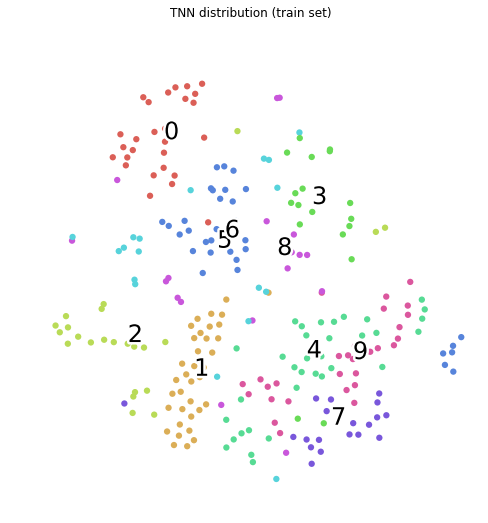

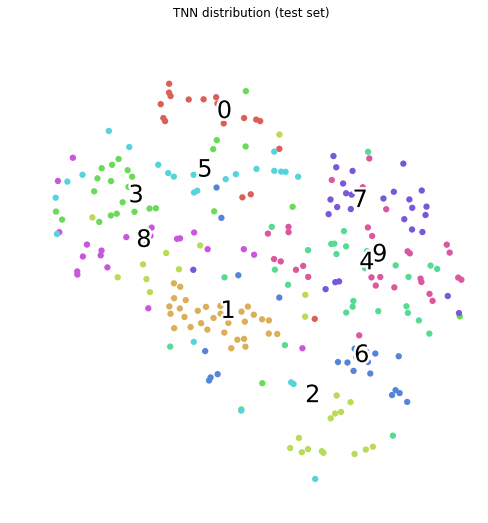

In [16]:
train_tsne_embeds = tsne.fit_transform(x_train.flatten(1).cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(x_test.flatten(1).cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), f'Original MNIST distribution (train set)')
scatter(test_tsne_embeds, y_test.cpu().numpy(), f'Original MNIST distribution (test set)')

In [6]:
model = Model.TNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [7]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss, pos_triplet, valid_triplet = Mining.online_mine_all(labels, outputs, margin=0.4, squared=True, device=device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2 == 0:
            print(f"At epoches = {epoch}, i = {i}, loss = {loss:.5f}, trainable_triplet = {pos_triplet}, total_triplets = {valid_triplet}"
                  , end='\r')
    epoch_loss = running_loss / len(train_loader)
    
    print(" "*100)
    print(f"At epoches = {epoch}, epoch_loss = {epoch_loss}")
print('Finished Training')

                                                                                                    
At epoches = 0, epoch_loss = 0.39230386881118123
                                                                                                    
At epoches = 1, epoch_loss = 0.39435596110972954
                                                                                                    
At epoches = 2, epoch_loss = 0.37831388515360814
                                                                                                    
At epoches = 3, epoch_loss = 0.3588999921337087
                                                                                                    
At epoches = 4, epoch_loss = 0.35421320276057466
                                                                                                    
At epoches = 5, epoch_loss = 0.3415857720882335
                                                                                                    
A

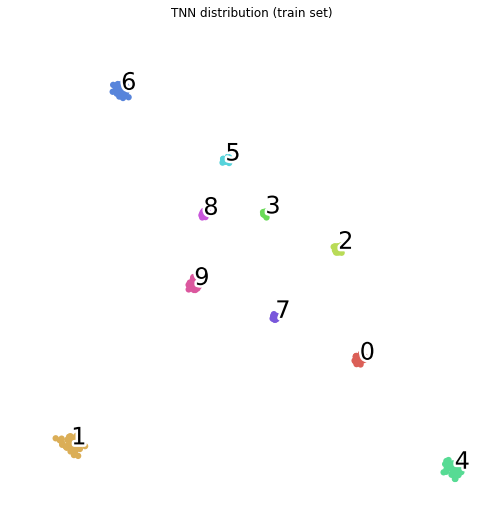

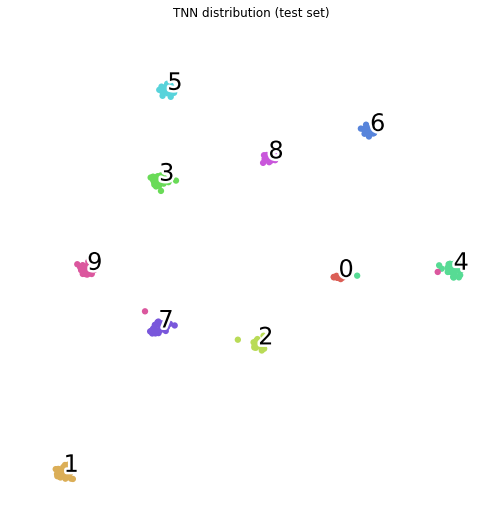

In [11]:
train_outputs = model(x_train)
test_outputs = model(x_test)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), f'TNN distribution (train set)')
scatter(test_tsne_embeds, y_test.cpu().numpy(), f'TNN distribution (test set)')